- Identifiziert meistgenutzte Start/End-Stationen und häufige Routenpaare.
- Aggregiert Fahrten pro Station und Route, visualisiert Rankings.
- Dient als Basis für Karten/Hotspot-Analysen in weiteren Schritten.


Lädt Fahrten (2023–2025), setzt Schema/Filter und Visual-Config; liefert LazyFrame scan als Basis.

In [ ]:
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl.Config.set_tbl_rows(500)
pl.Config.set_tbl_cols(500)



sns.set_theme(style="whitegrid")

DATA_DIR = Path("../../raw_data/citi_bike")
FILES = (sorted(DATA_DIR.glob("2023-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2024-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2025-citibike-tripdata/*.csv")))

SCHEMA = {
    "ride_id": pl.Utf8,
    "rideable_type": pl.Utf8,
    "started_at": pl.Datetime,
    "ended_at": pl.Datetime,
    "start_station_name": pl.Utf8,
    "start_station_id": pl.Utf8,
    "end_station_name": pl.Utf8,
    "end_station_id": pl.Utf8,
    "start_lat": pl.Float32,
    "start_lng": pl.Float32,
    "end_lat": pl.Float32,
    "end_lng": pl.Float32,
    "member_casual": pl.Utf8,
}

scan = (
    pl.scan_csv([str(p) for p in FILES], schema=SCHEMA, try_parse_dates=True, ignore_errors=True)
    .filter(
        (pl.col("started_at").dt.year() >= 2023) & (pl.col("started_at").dt.year() <= 2025) &
        (pl.col("ended_at").dt.year() >= 2023) & (pl.col("ended_at").dt.year() <= 2025)
    )
)

Berechnet Top-Startstationen gesamt inkl. %-Anteil

In [ ]:
total_starts = (
    scan.filter(pl.col("start_station_name").is_not_null())
    .select(pl.len().alias("total"))
    .collect()["total"][0]
)

start_top = (
    scan.filter(pl.col("start_station_name").is_not_null())
    .group_by("start_station_name")
    .agg(pl.len().alias("rides"))
    .sort("rides", descending=True)
    .limit(10)
    .with_columns(
        ((pl.col("rides") / pl.lit(total_starts)) * 100).round(2).alias("pct")
    )
    .collect()
)

start_top


start_station_name,rides,pct
str,u32,f64
"""W 21 St & 6 Ave""",470221,0.38
"""West St & Chambers St""",386992,0.31
"""Broadway & W 58 St""",381899,0.31
"""University Pl & E 14 St""",377539,0.3
"""W 31 St & 7 Ave""",369325,0.3
"""11 Ave & W 41 St""",364341,0.29
"""Lafayette St & E 8 St""",358527,0.29
"""Broadway & E 14 St""",354431,0.28
"""Broadway & W 25 St""",341933,0.27


Berechnet Top-Startstationen pro Jahr mit Prozentanteil und Rang

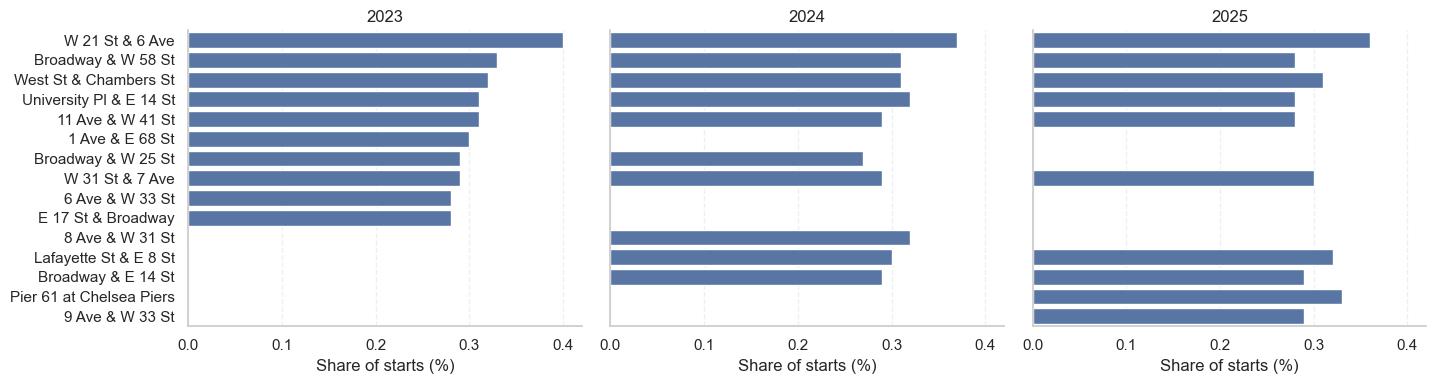

In [ ]:
start_top_by_year = (
    scan.filter(pl.col("start_station_name").is_not_null() & pl.col("started_at").is_not_null())
    .with_columns(pl.col("started_at").dt.year().alias("year"))
    .group_by(["year", "start_station_name"])
    .agg(pl.len().alias("rides"))
    .with_columns([
        ((pl.col("rides") / pl.sum("rides").over("year")) * 100).round(2).alias("pct"),
        pl.col("rides").rank(method="ordinal", descending=True).over("year").alias("rank"),
    ])
    .filter(pl.col("rank") <= 10)
    .sort(["year", "rides"], descending=[False, True])
    .select(["year", "start_station_name", "rides", "pct"])
    .collect()
)

df = start_top_by_year.to_pandas().sort_values(["year", "pct"], ascending=[True, False])

g = sns.catplot(
    data=df,
    kind="bar",
    x="pct",
    y="start_station_name",
    col="year",
    col_wrap=3,
    height=4,
    aspect=1.2,
    color="C0"
)
g.set_axis_labels("Share of starts (%)", "")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()

Berechnet Top-Endstationen gesamt inkl. %-Anteil

In [ ]:
total_ends = (
    scan.filter(pl.col("end_station_name").is_not_null())
    .select(pl.len().alias("total"))
    .collect()["total"][0]
)

end_top = (
    scan.filter(pl.col("end_station_name").is_not_null())
    .group_by("end_station_name")
    .agg(pl.len().alias("rides"))
    .sort("rides", descending=True)
    .limit(10)
    .with_columns(
        ((pl.col("rides") / pl.lit(total_ends)) * 100).round(2).alias("pct")
    )
    .collect()
)

end_top

end_station_name,rides,pct
str,u32,f64
"""W 21 St & 6 Ave""",471428,0.38
"""West St & Chambers St""",389041,0.31
"""University Pl & E 14 St""",382740,0.31
"""Broadway & W 58 St""",374856,0.3
"""W 31 St & 7 Ave""",369463,0.3
"""11 Ave & W 41 St""",363400,0.29
"""Lafayette St & E 8 St""",360135,0.29
"""Broadway & E 14 St""",351124,0.28
"""Broadway & W 25 St""",342980,0.27


Berechnet Top-Endstationen pro Jahr mit Prozentanteil und Rang

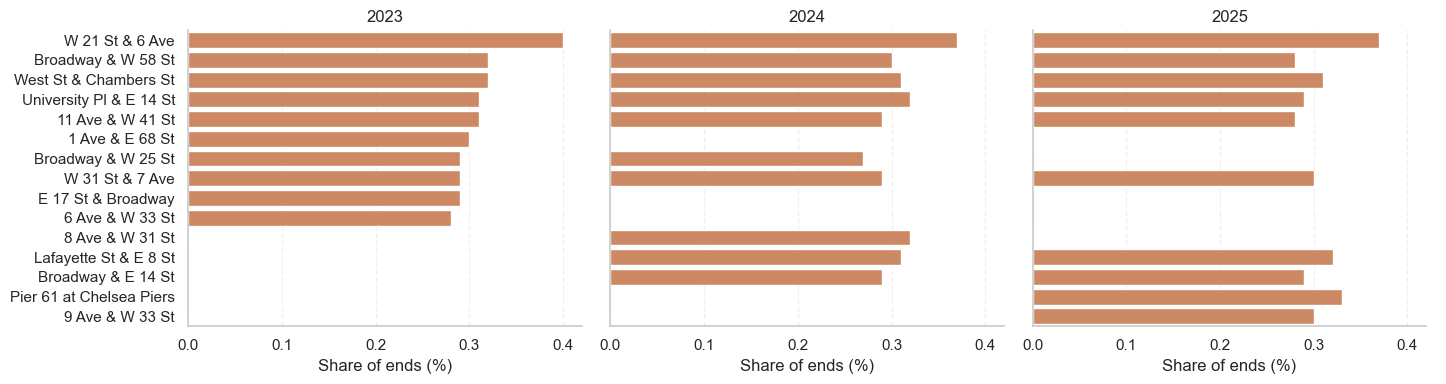

In [ ]:
end_top_by_year = (
    scan.filter(pl.col("end_station_name").is_not_null() & pl.col("ended_at").is_not_null())
    .with_columns(pl.col("ended_at").dt.year().alias("year"))
    .group_by(["year", "end_station_name"])
    .agg(pl.len().alias("rides"))
    .with_columns([
        ((pl.col("rides") / pl.sum("rides").over("year")) * 100).round(2).alias("pct"),
        pl.col("rides").rank(method="ordinal", descending=True).over("year").alias("rank"),
    ])
    .filter(pl.col("rank") <= 10)
    .sort(["year", "rides"], descending=[False, True])
    .select(["year", "end_station_name", "rides", "pct"])
    .collect()
)

df_end = end_top_by_year.to_pandas().sort_values(["year", "pct"], ascending=[True, False])

g_end = sns.catplot(
    data=df_end,
    kind="bar",
    x="pct",
    y="end_station_name",
    col="year",
    col_wrap=3,
    height=4,
    aspect=1.2,
    color="C1"
)
g_end.set_axis_labels("Share of ends (%)", "")
g_end.set_titles("{col_name}")
for ax_ in g_end.axes.flat:
    ax_.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()

Berechnet Net-Outflow je Station (Starts minus Ends), gibt Top Ab-/Zuflüsse aus

In [ ]:
start_counts = (
    scan.filter(pl.col("start_station_name").is_not_null())
    .group_by("start_station_name")
    .agg(pl.len().alias("start_rides"))
    .rename({"start_station_name": "station_name"})
)

end_counts = (
    scan.filter(pl.col("end_station_name").is_not_null())
    .group_by("end_station_name")
    .agg(pl.len().alias("end_rides"))
    .rename({"end_station_name": "station_name"})
)

station_balance = (
    start_counts.join(end_counts, on="station_name", how="full")
    .with_columns(
        pl.col("station_name").fill_null(pl.col("station_name_right")),
        pl.col("start_rides").fill_null(0),
        pl.col("end_rides").fill_null(0),
    )
    .drop("station_name_right")
    .with_columns(
        (pl.col("start_rides").cast(pl.Int64) - pl.col("end_rides").cast(pl.Int64)).alias("net_outflow")
    )
)

net_out = station_balance.sort("net_outflow", descending=True).limit(15).collect()
net_in = station_balance.sort("net_outflow").limit(15).collect()

net_out, net_in


(shape: (15, 4)
 ┌───────────────────────────────┬─────────────┬───────────┬─────────────┐
 │ station_name                  ┆ start_rides ┆ end_rides ┆ net_outflow │
 │ ---                           ┆ ---         ┆ ---       ┆ ---         │
 │ str                           ┆ u32         ┆ u32       ┆ i64         │
 ╞═══════════════════════════════╪═════════════╪═══════════╪═════════════╡
 │ Broadway & W 56 St            ┆ 184704      ┆ 155560    ┆ 29144       │
 │ W 49 St & 8 Ave               ┆ 154336      ┆ 136405    ┆ 17931       │
 │ Broadway & W 53 St            ┆ 186006      ┆ 173558    ┆ 12448       │
 │ Plaza St East & Flatbush Ave  ┆ 142972      ┆ 133268    ┆ 9704        │
 │ W 56 St & 10 Ave              ┆ 155958      ┆ 146516    ┆ 9442        │
 │ …                             ┆ …           ┆ …         ┆ …           │
 │ Broadway & W 58 St            ┆ 381899      ┆ 374856    ┆ 7043        │
 │ W 50 St & 10 Ave              ┆ 149359      ┆ 142352    ┆ 7007        │
 │ E 35 S

Berechnet Anteil der Fahrten und der eindeutigen Routen, bei denen Start=End

In [ ]:
both_names = pl.col("start_station_name").is_not_null() & pl.col("end_station_name").is_not_null()

# Rides-level share
total_with_both = (
    scan.filter(both_names)
    .select(pl.len().alias("total"))
    .collect()["total"][0]
)
equal_count = (
    scan.filter(both_names & (pl.col("start_station_name") == pl.col("end_station_name")))
    .select(pl.len().alias("equal"))
    .collect()["equal"][0]
)
pct_rides = (equal_count / total_with_both * 100) if total_with_both else float("nan")

# Unique route pairs share
unique_total = (
    scan.filter(both_names)
    .select(["start_station_name", "end_station_name"])
    .unique()
    .select(pl.len().alias("n"))
    .collect()["n"][0]
)
unique_equal = (
    scan.filter(both_names & (pl.col("start_station_name") == pl.col("end_station_name")))
    .select(["start_station_name", "end_station_name"])
    .unique()
    .select(pl.len().alias("n"))
    .collect()["n"][0]
)
pct_unique = (unique_equal / unique_total * 100) if unique_total else float("nan")

print(f"Share of rides with start=end: {pct_rides:.2f}% ({equal_count:,}/{total_with_both:,})")
print(f"Share of unique routes with start=end: {pct_unique:.2f}% ({unique_equal:,}/{unique_total:,})")

Share of rides with start=end: 2.34% (2,924,728/124,807,696)
Share of unique routes with start=end: 0.11% (2,404/2,224,703)


Ermittelt die 20 häufigsten Routen (Start≠End) und fügt %-Anteil relativ zu allen solchen Fahrten hinzu

In [ ]:
denom_diff = total_with_both - equal_count

top_routes = (
    scan.filter(
        pl.col("start_station_name").is_not_null() & 
        pl.col("end_station_name").is_not_null() &
        (pl.col("start_station_name") != pl.col("end_station_name"))
    )
    .group_by(["start_station_name", "end_station_name"])
    .agg(pl.len().alias("rides"))
    .sort("rides", descending=True)
    .limit(20)
    .with_columns(
        pl.when(pl.lit(denom_diff) > 0)
        .then(((pl.col("rides") / pl.lit(denom_diff)) * 100).round(6))
        .otherwise(pl.lit(float("nan")))
        .alias("pct")
    )
    .collect()
)

top_routes


start_station_name,end_station_name,rides,pct
str,str,u32,f64
"""W 21 St & 6 Ave""","""9 Ave & W 22 St""",16606,0.013625
"""Norfolk St & Broome St""","""Henry St & Grand St""",16058,0.013175
"""Henry St & Grand St""","""Norfolk St & Broome St""",14970,0.012282
"""North Moore St & Greenwich St""","""Vesey St & Church St""",14918,0.01224
"""West St & Chambers St""","""Pier 40 - Hudson River Park""",14586,0.011967
"""Roosevelt Island Tramway""","""Motorgate""",14409,0.011822
"""E 77 St & 1 Ave""","""E 77 St & 3 Ave""",14357,0.011779
"""1 Ave & E 62 St""","""1 Ave & E 68 St""",14261,0.011701
"""11 Ave & W 41 St""","""W 34 St & Hudson Blvd E""",14185,0.011638


: 